**4f optical system:**

    See notes at the bottom for mathematical derivations and reasoning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
import math
from astropy.convolution import Tophat2DKernel, convolve

# basic imports and beginning parameters

wvl = 200e-9 # wavelength
f = 10 # distance
img_size = 0.5e-3 # image size
num_pixels = 512 # number of pixels

k = 2*np.pi/wvl

d_length: 20.480000000000018
d_lower: 245.76
d_upper: 266.24
d_avg: 256.0


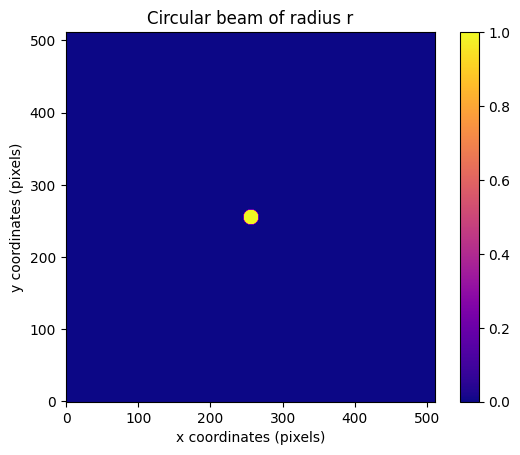

In [2]:
pix_size = img_size/num_pixels # the length each pixel is

x = np.linspace(-img_size/2, img_size/2, num_pixels) # spatial grid size
xv, yv = np.meshgrid(x,x)

# line below defines object to be Gaussian beam
# un-comment the line below, and comment next part to see results
#u_in = np.exp(-2*(xv**2 + yv**2)/(img_size/120)**2)

# defines object to be perfect circle beam with radius r
r = 10e-6
u_in = (xv**2 < r**2 - yv**2)
u_in = u_in.astype(float)

r_pixels = r/pix_size # pixel size
d_lower = num_pixels/2 - r_pixels # pixel position where circle begins
d_upper = num_pixels/2 + r_pixels # pixel position where circle ends
d_length = d_upper - d_lower # pixel diameter of circle beam
print("d_length:", d_length)
print("d_lower:", d_lower)
print("d_upper:", d_upper)
d_avg = (d_lower+d_upper)/2 # middle point of circle beam
print("d_avg:", d_avg)

# for good sizing of the final intensity image, ensure that d_length ~ 20
#clarifying these positions ensures the code isn't dependent upon pixel number

# plotting the object

plt.imshow(u_in, cmap = 'plasma', origin = 'lower')
plt.title("Circular beam of radius r")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")
plt.colorbar()



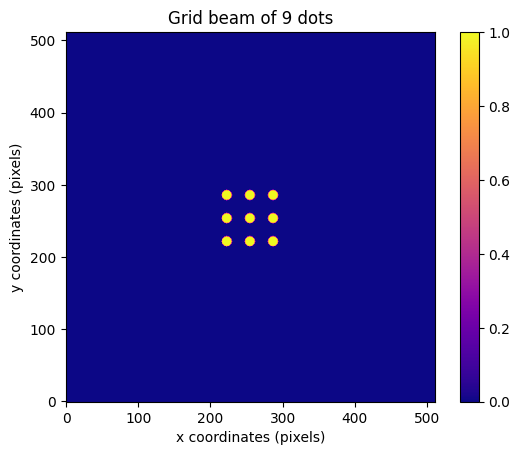

In [3]:
radius = 7 # size of dots

n1 = num_pixels
dist = 32 # distance between center of dots
mid = int(dist/2)
length = 100
# change length to change the number of dots

kernel = Tophat2DKernel(radius=radius)

# ^ creates circle position of a single dot

Z = np.zeros((n1, n1))

for i in range(int(mid+(n1-length)/2), int(n1-(n1-length)/2), dist):
    for j in range(int(mid+(n1-length)/2), int(n1-(n1-length)/2), dist):
        Z[i, j] = 1

# ^ creates Dirac comb of points

uin_alt = convolve(Z, kernel)
uin_alt = (uin_alt - np.min(uin_alt))/(np.max(uin_alt) - np.min(uin_alt))
# convolves Dirac comb with circle, and normalises

# image of points
plt.imshow(uin_alt, cmap = 'plasma', origin = 'lower')
plt.title("Grid beam of 9 dots")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")
plt.colorbar()



In [4]:
u_in = uin_alt # comment out for single point source, uncomment for grid of dots

Text(0, 0.5, 'Intensity')

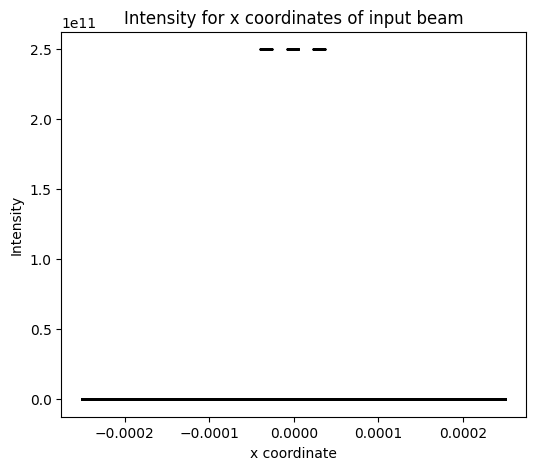

In [5]:
I1 = (1/(wvl*f))**2*np.abs(u_in)**2 # calculating intensity using formula described in notes below
plt.figure(figsize=(6,5))
plt.plot(xv, I1,'ko', markersize = 0.5, ls = 'none')
plt.title("Intensity for x coordinates of input beam")
plt.xlabel("x coordinate")
plt.ylabel("Intensity")

Text(0, 0.5, 'y coordinates (pixels)')

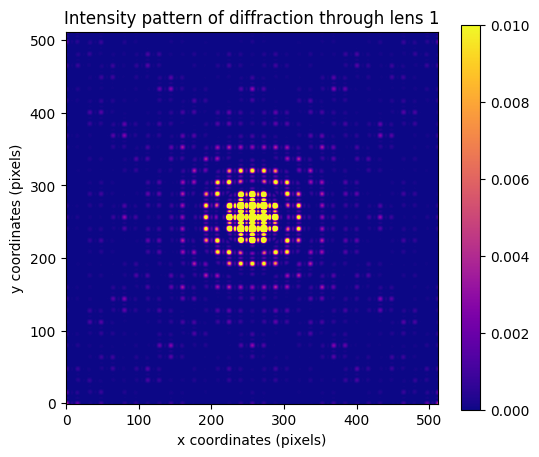

In [6]:
# plotting the intensity for u1

#u1_fft = np.exp(2*1j*f*k)/(1j*wvl*f)*fft2(u_in)
u1_fft = np.exp(2*1j*f*k)/(1j*wvl*f)*fft2(u_in) 
u1 = fftshift(u1_fft) # Fourier transforming it and moving frequencies into suitable region
u1  = ifftshift(u1)

I1 = np.abs(u1)**2 # calculating intensity using formula described in notes below
I1_normalised = (I1 - np.min(I1))/(np.max(I1) - np.min(I1))
I1_normalised = fftshift(I1_normalised)

plt.figure(figsize=(6,5))
plt.imshow(I1_normalised, cmap='plasma', origin = 'lower') # plotting intensity

plt.clim(0, 0.01) # sets limit for colorbar
plt.colorbar()

plt.title("Intensity pattern of diffraction through lens 1")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")

Text(0, 0.5, 'Intensity')

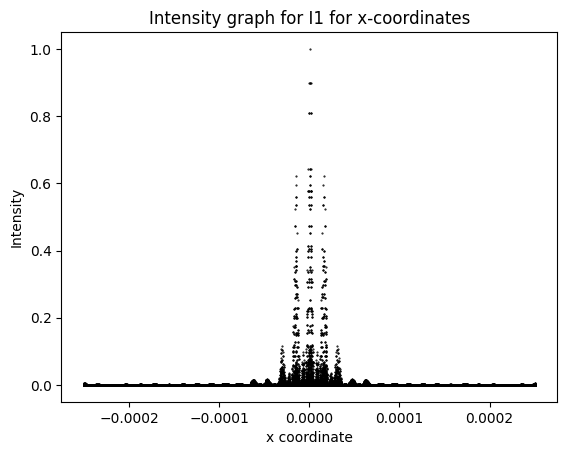

In [7]:
# plotting intensity graph for x and y
plt.plot(xv, I1_normalised,'ko', markersize = 0.5, ls = 'none')
plt.title("Intensity graph for I1 for x-coordinates")
plt.xlabel("x coordinate")
plt.ylabel("Intensity")

Text(0, 0.5, 'Intensity')

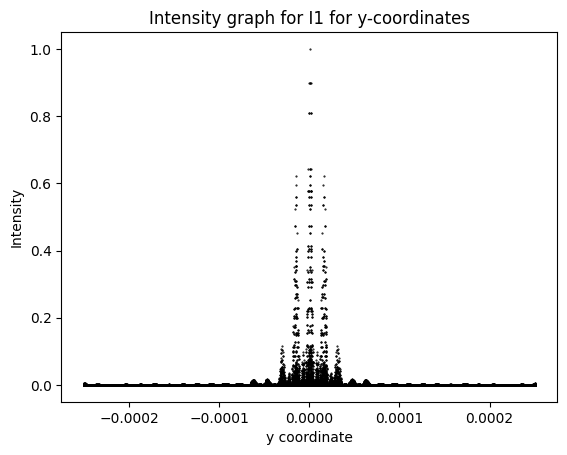

In [8]:
plt.plot(yv, I1_normalised,'ko', markersize = 0.5, ls = 'none')
plt.title("Intensity graph for I1 for y-coordinates")
plt.xlabel("y coordinate")
plt.ylabel("Intensity")

Text(0, 0.5, 'y coordinates (pixels)')

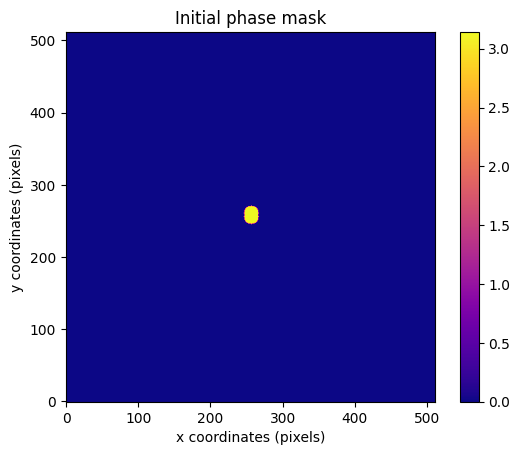

In [9]:
# applying phase mask

# t_lens(r) = A exp (-i pi r^2/(lambda * f)) t_ap(r)

amp_mask = np.zeros((num_pixels, num_pixels))
# creates amplitude mask of two overlapping circles
coords1 = [(int(d_lower+d_length/2), int(d_avg)), (int(d_upper-d_length/4), int(d_avg))]
radius1 = int(d_length/2)
for position in coords1:
    x, y = position
    for i in range(max(0, x - radius1), min(num_pixels, x + radius1 + 1)):
        for j in range(max(0, y - radius1), min(num_pixels, y + radius1 + 1)):
            distance = np.sqrt((i - x)**2 + (j - y)**2)
            if distance <= radius1:  # If within the radius, apply phase shift
                amp_mask[i, j] = 1


phase_mask = np.zeros((num_pixels, num_pixels))
# creates phase mask of two overlapping circles
coords = [(int(d_lower+d_length/2), int(d_avg)), (int(d_upper - d_length/4), int(d_avg))]
radius = int(d_length/2)
for position in coords:
    x, y = position
    for i in range(max(0, x - radius), min(num_pixels, x + radius + 1)):
        for j in range(max(0, y - radius), min(num_pixels, y + radius + 1)):
            distance = np.sqrt((i - x)**2 + (j - y)**2)
            if distance <= radius:  # If within the radius, apply phase shift
                phase_mask[i, j] = np.pi

amp_mask_2 = 1

u1 = amp_mask*np.exp(1j*phase_mask)*u1
#u1 = amp_mask_2*u1
# plots amp_mask or phase_mask
plt.imshow(phase_mask, origin='lower', cmap='plasma')
plt.colorbar()
plt.title("Initial phase mask")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")

Text(0, 0.5, 'y coordinates (pixels)')

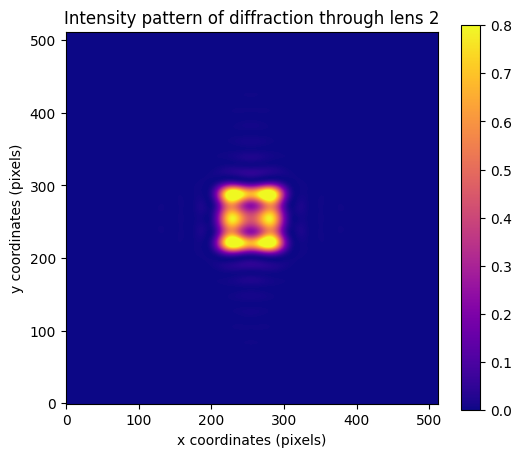

In [10]:
# propagating through second lens
u_out = u1

u2_fft = np.exp(2*1j*f*k)/(1j*wvl*f)*ifft2(u_out)
u2 = fftshift(u2_fft)

I2 = np.abs(u2)**2
I2_normalised = (I2 - np.min(I2))/(np.max(I2) - np.min(I2))
I2_normalised = fftshift(I2_normalised)
# normalising function

plt.figure(figsize=(6,5))
plt.imshow(I2_normalised, cmap='plasma', origin='lower')
plt.clim(0, 0.8) #adjusts limits of colorbar for better visibility
plt.colorbar()
plt.title("Intensity pattern of diffraction through lens 2")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")

Text(0, 0.5, 'y coordinates (pixels)')

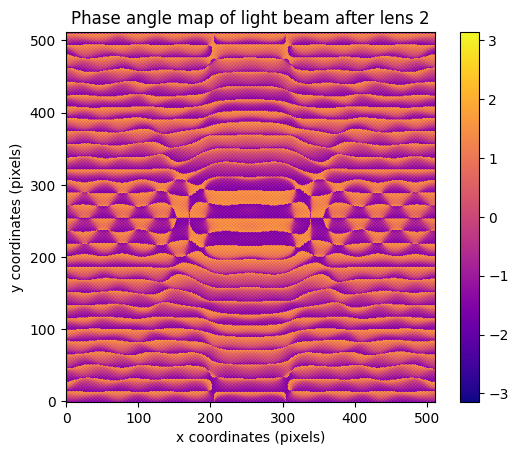

In [11]:
# plots phase map
plt.imshow(np.angle(fftshift(u2)), origin='lower', cmap='plasma')
plt.colorbar()
plt.title("Phase angle map of light beam after lens 2")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")

Text(0, 0.5, 'Intensity')

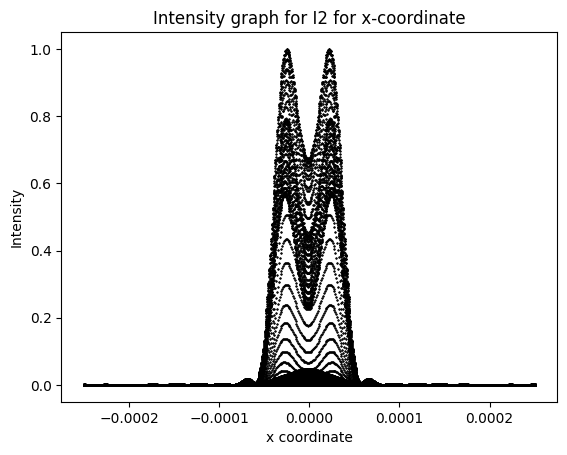

In [12]:
# plot of intensity for x coordinate
plt.plot(xv, I2_normalised, 'ko', markersize = 0.5, ls = 'none')
plt.title("Intensity graph for I2 for x-coordinate")
plt.xlabel("x coordinate")
plt.ylabel("Intensity")
#plt.xlim(-0.00005, 0.00005)

Text(0, 0.5, 'Intensity')

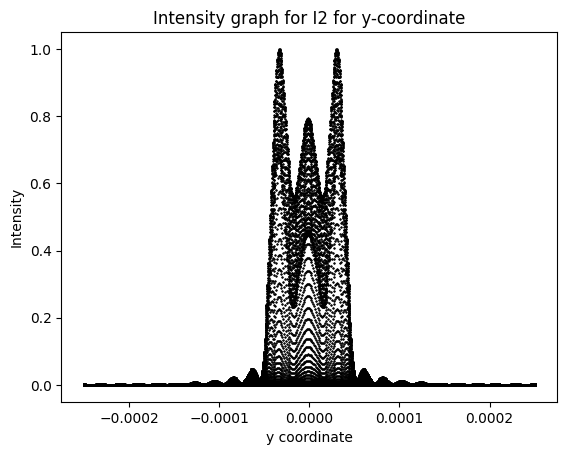

In [13]:
# plot of intensity for y coordinate
plt.plot(yv, I2_normalised, 'ko', markersize = 0.5, ls = 'none')
plt.title("Intensity graph for I2 for y-coordinate")
plt.xlabel("y coordinate")
plt.ylabel("Intensity")

In [14]:
# converts u2 (final propagate image) to fits file if necessary
from astropy.io import fits

real_part = np.real(u2)
imag_part = np.imag(u2)

hdu_real = fits.ImageHDU(data=real_part, name='REAL')
hdu_imag = fits.ImageHDU(data=imag_part, name='IMAG')

hdul = fits.HDUList([fits.PrimaryHDU(), hdu_real, hdu_imag])
hdul.writeto('proc_val_2.fits', overwrite=True)


In [15]:
# converts jupyter notebook to to Python file if necessary
!jupyter nbconvert --to script Fourf_optical_system_simulation_v1.ipynb

[NbConvertApp] Converting notebook Fourf_optical_system_simulation_v1.ipynb to script
[NbConvertApp] Writing 9163 bytes to Fourf_optical_system_simulation_v1.py


**Notes:**

The Huygens-Fresnel principle is
$$u_1(x_1, y_1) = \int \int^\infty_{-\infty} u_0(x_0, y_0) \frac{z_{01}}{j\lambda r_{01}} \frac{e^{jkr_{01}}}{r_{01}} dx_0 dy_0$$
where
$$r_{01} = \sqrt{(x_1 - x_0)^2 + (y_1 - y0)^2 + (z_1 - z_0)^2}$$

Due to exponent being nonlinear, it is difficult to computate. As such, when in Far-Field Fresnel zone, we can approximate the propagation of light through lens 1 as
$$u_\text{lens 1}(\mathbf{r_2}) = \frac{e^{2ikf}}{i\lambda f} \mathcal{F}(u_{\text{input}}(\mathbf{r_1}))\left. \right|_{\mathbf{\rho}=\frac{\mathbf{r}_f}{\lambda f}},$$
where $k = \frac{2\pi}{\lambda}$ is the wavenumber, and $\rho$ links the physical position in the focal plane to the spatial frequency and $\mathcal{F}$ is the Fourier transform.

The amplitude mask $A(x,y)$ and phase mask $\phi(x,y)$ is applied by
$$u_\text{modified} = A(x,y) u_\text{plane}e^{i\phi(x,y)}.$$

Propagating through the second lens, using the same propagation method as for lens 1.
$$u_\text{output}(\mathbf{r_3}) = \frac{e^{2ikf}}{i\lambda f} \mathcal{F}^{-1}(u_\text{modified}(\mathbf{r_2})),$$
where $\mathcal{F}^{-1}$ is the inverse Fourier transform.

**Further notes from  *A Field Guide to Linear Systems* (Tyo et al., 2015):**
A lens applies transformation:
$$t_{lens}(\textbf{r}) = A \exp(-\frac{i\pi r^2}{\lambda f}) t_{ap}(\textbf{r})$$
with complex constant $A$.

When $A = 1$, with $z = -f$ to $z=+f$,
$$u_2(\textbf{r}_2) = \frac{e^{ik2f}}{i\lambda f} F(u_1(\textbf{r}_1))|_{\textbf{p}=\frac{\textbf{r}_f}{\lambda f}} = \frac{e^{ik2f}}{i\lambda f} U_1(\frac{\textbf{r}_2}{\lambda f}).$$

The object's Fourier domain can be modified by placing filter at $z = z_2$:
$$u_2(\textbf{r}_2)=\frac{e^{ik2f}}{i\lambda f} U_1(\frac{\textbf{r}_2}{\lambda f})t_{filter}(\textbf{r}_2).$$


In order to normalise the intensity, we use the formula
$$I_{normalised} = \frac{I - \text{min}(I)}{\text{range}(I)}.$$

We can simulate a 4f optical system by:
1. Establishing shape of object.
2. Propagate the beam through the first lens and use Fourier transform.
3. Apply phase and amplitude mask to light beam.
4. Propogate beam through second lens and use inverse Fourier transform.
5. Visualise image, and save final array of beam.
6. Pass data onto DM method.